In [24]:
import autoreg
import GPy
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function
%matplotlib inline

from autoreg.benchmark import tasks

In [25]:
# Function to compute root mean square error:

def comp_RMSE(a,b):
    return np.sqrt(np.square(a-b).mean())

In [26]:
# Define class for normalization
class Normalize(object):
    
    def __init__(self, data, name, norm_name):
        
        self.data_mean = data.mean(axis=0)
        self.data_std = data.std(axis=0)
        self.normalization_computed = True
        
        setattr(self, name, data)                         
        setattr(self, norm_name, (data-self.data_mean) / self.data_std )
        
    def normalize(self, data, name, norm_name):
            if hasattr(self,norm_name):
                raise ValueError("This normalization name already exist, choose another one")
            
            setattr(self, name, data )
            setattr(self, norm_name, (data-self.data_mean) / self.data_std )
            
            
                                     
    def denormalize(self, data):
                                   
        return data*self.data_std + self.data_mean    

In [27]:
trainned_models_folder_name = "/Users/grigoral/work/code/RGP/examples/identif_trainded"
task_name = 'Drive'
# task names:
# Actuator, Ballbeam, Drive, Gas_furnace, Flutter, Dryer, Tank,
# IdentificationExample1..5

In [28]:
task = getattr( tasks, task_name)
task = task()
task.load_data()
print("Data OUT train shape:  ", task.data_out_train.shape)
print("Data IN train shape:  ", task.data_in_train.shape)
print("Data OUT test shape:  ", task.data_out_test.shape)
print("Data IN test shape:  ", task.data_in_test.shape)

Data OUT train shape:   (250, 1)
Data IN train shape:   (250, 1)
Data OUT test shape:   (250, 1)
Data IN test shape:   (250, 1)


### Normalize training and test data:

In [29]:
normalize = False
in_data = Normalize(task.data_in_train,'in_train','in_train_norm' )
out_data = Normalize(task.data_out_train,'out_train','out_train_norm' )

in_data.normalize(task.data_in_test, 'in_test','in_test_norm')
out_data.normalize(task.data_out_test, 'out_test','out_test_norm')

if normalize:
    out_train = out_data.out_train_norm #out_data.out_train 
    in_train = in_data.in_train_norm # in_data.in_train
    out_test = out_data.out_test_norm #out_data.out_test
    in_test = in_data.in_test_norm #in_data.in_test
else:
    out_train = out_data.out_train  #out_data.out_train 
    in_train = in_data.in_train # in_data.in_train
    out_test = out_data.out_test #out_data.out_test
    in_test = in_data.in_test #in_data.in_test
    
print("Training OUT mean:  ", out_train.mean(0)); 
print("Training OUT std:  ", out_train.std(0))
print("")
print("Test OUT mean:  ", out_test.mean(0)); 
print("Test OUT std:  ", out_test.std(0))
print("")
print("Training IN mean:  ", in_train.mean(0)); 
print("Training IN std:  ", in_train.std(0))
print("")
print("Test IN mean:  ", in_test.mean(0)); 
print("Test IN std:  ", in_test.std(0))

Training OUT mean:   [ -7.10542736e-18]
Training OUT std:   [ 1.]

Test OUT mean:   [-0.00241894]
Test OUT std:   [ 1.070077]

Training IN mean:   [ 0.]
Training IN std:   [ 1.]

Test IN mean:   [-0.3646984]
Test IN std:   [ 0.99258333]


### Plot training and test data:

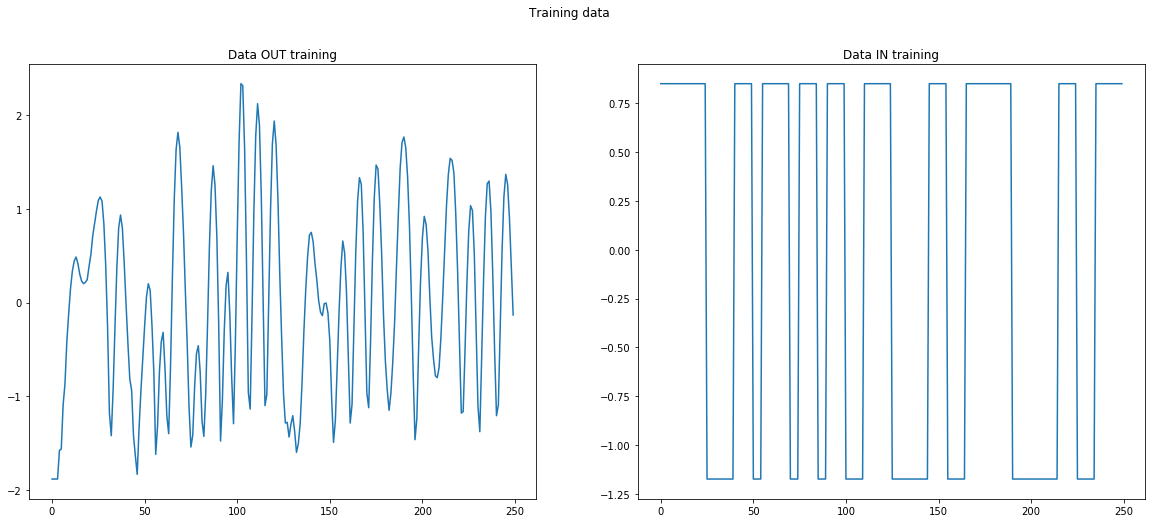

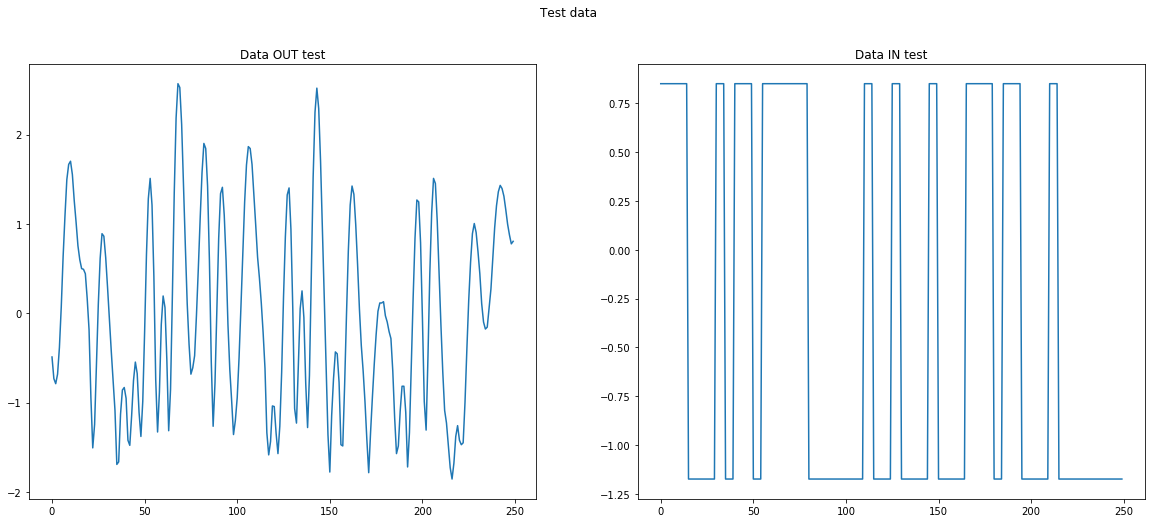

In [30]:
# Plot training:
fig1 = plt.figure(1,figsize=(20,8))
fig1.suptitle('Training data')
ax1 = plt.subplot(1,2,1)
ax1.plot(out_train)
ax1.set_title('Data OUT training')

ax2 = plt.subplot(1,2,2)
ax2.plot(in_train)
ax2.set_title('Data IN training')

fig2 = plt.figure(2,figsize=(20,8))
fig2.suptitle('Test data')
ax3 = plt.subplot(1,2,1)
ax3.plot(out_test)
ax3.set_title('Data OUT test')

ax4 = plt.subplot(1,2,2)
ax4.plot(in_test)
ax4.set_title('Data IN test')

del ax1, ax2, ax3, ax4

### Model definition:

In [31]:
Q = 50 # 200 # Inducing points num
win_in = task.win_in # 20
win_out = task.win_out # 20
use_controls = True
back_cstr = False
inference_method = None

# 1 layer:
#wins = [0, win_out] # 0-th is output layer
#nDims = [out_train.shape[1],1]

# 2 layers:
wins = [0, win_out, win_out]
nDims = [out_train.shape[1],1,1]

MLP_dims = [300,200]
print("Input window:  ", win_in)
print("Output window:  ", win_out)


m = autoreg.DeepAutoreg(wins, out_train, U=in_train, U_win=win_in,
                        num_inducing=Q, back_cstr=back_cstr, MLP_dims=MLP_dims, nDims=nDims,
                        #init='Y', # how to initialize hidden states means
                        X_variance=0.05, # how to initialize hidden states variances
                        #inference_method=inference_method, # Inference method
                        # 1 layer:
                        #kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True),
                        #         GPy.kern.RBF(win_in + win_out,ARD=True,inv_l=True)] )

                        # 2 layers:
                        kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True),
                                 GPy.kern.RBF(win_out+win_out,ARD=True,inv_l=True),
                                 GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True)])
        
#m = autoreg.DeepAutoreg([0,win_out],out_train, U=in_train, U_win=win_in,X_variance=0.01,
#                        num_inducing=50)

# pattern for model name: #task_name, inf_meth=?, wins=layers, Q = ?, backcstr=?,MLP_dims=?, nDims=
model_file_name = '%s--inf_meth=%s--wins=%s--Q=%i--backcstr=%i--nDims=%s' % (task.name, 
    'reg' if inference_method is None else inference_method, str(wins), Q, back_cstr, str(nDims))
if back_cstr == True:
    model_file_name += '--MLP_dims=%s' % (MLP_dims,)
    
print('Model file name:  ',  model_file_name)
print(m)

Input window:   10
Output window:   10
Model file name:   drive--inf_meth=reg--wins=[0, 10, 10]--Q=50--backcstr=0--nDims=[1, 1, 1]

Name : autoreg
Objective : 27660.2602839
Number of Parameters : 3556
Number of Optimization Parameters : 3556
Updates : True
Parameters:
  autoreg.                         |     value  |  constraints  |  priors
  layer_2.inducing_inputs          |  (50, 20)  |               |        
  layer_2.rbf.variance             |       1.0  |      +ve      |        
  layer_2.rbf.inv_lengthscale      |     (20,)  |      +ve      |        
  layer_2.Gaussian_noise.variance  |      0.01  |      +ve      |        
  layer_2.qX_0.mean                |  (250, 1)  |               |        
  layer_2.qX_0.variance            |  (250, 1)  |      +ve      |        
  layer_1.inducing_inputs          |  (50, 20)  |               |        
  layer_1.rbf.variance             |       1.0  |      +ve      |        
  layer_1.rbf.inv_lengthscale      |     (20,)  |      +ve      |

### Model initialization:

In [32]:
# Here layer numbers are different than in initialization. 0-th layer is the top one
for i in range(m.nLayers):
    m.layers[i].kern.inv_l[:]  = np.mean( 1./((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.)) )
    m.layers[i].likelihood.variance[:] = 0.01*out_train.var()
    m.layers[i].kern.variance.fix(warning=False)
    m.layers[i].likelihood.fix(warning=False)
print(m)


Name : autoreg
Objective : 19622.3369208
Number of Parameters : 3556
Number of Optimization Parameters : 3550
Updates : True
Parameters:
  autoreg.                         |     value  |  constraints  |  priors
  layer_2.inducing_inputs          |  (50, 20)  |               |        
  layer_2.rbf.variance             |       1.0  |   fixed +ve   |        
  layer_2.rbf.inv_lengthscale      |     (20,)  |      +ve      |        
  layer_2.Gaussian_noise.variance  |      0.01  |   fixed +ve   |        
  layer_2.qX_0.mean                |  (250, 1)  |               |        
  layer_2.qX_0.variance            |  (250, 1)  |      +ve      |        
  layer_1.inducing_inputs          |  (50, 20)  |               |        
  layer_1.rbf.variance             |       1.0  |   fixed +ve   |        
  layer_1.rbf.inv_lengthscale      |     (20,)  |      +ve      |        
  layer_1.Gaussian_noise.variance  |      0.01  |   fixed +ve   |        
  layer_1.qX_0.mean                |  (250, 1)  

In [33]:
print(m.layer_1.kern.inv_l)
print(m.layer_0.kern.inv_l)
print( np.mean(1./((m.layer_1.X.mean.values.max(0)-m.layer_1.X.mean.values.min(0))/np.sqrt(2.))) )

  index  |  autoreg.layer_1.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.33921267  |      +ve      |        
  [1]    |                           0.33921267  |      +ve      |        
  [2]    |                           0.33921267  |      +ve      |        
  [3]    |                           0.33921267  |      +ve      |        
  [4]    |                           0.33921267  |      +ve      |        
  [5]    |                           0.33921267  |      +ve      |        
  [6]    |                           0.33921267  |      +ve      |        
  [7]    |                           0.33921267  |      +ve      |        
  [8]    |                           0.33921267  |      +ve      |        
  [9]    |                           0.33921267  |      +ve      |        
  [10]   |                           0.33921267  |      +ve      |        
  [11]   |                           0.33921267  |      +ve      |        
  [12]   |               

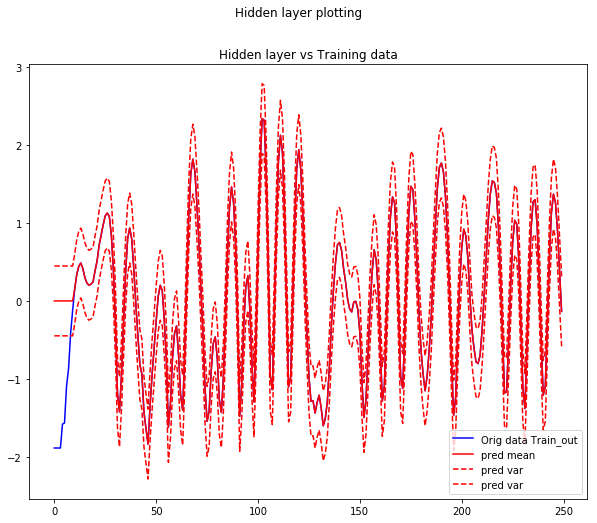

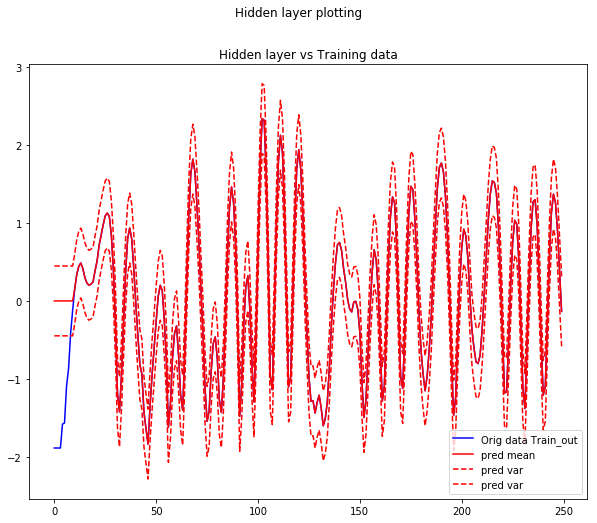

In [34]:
# Plot initialization of hidden layer:
def plot_hidden_states(fig_no, layer, layer_start_point=None, layer_end_point=None,
                              data_start_point=None, data_end_point=None):
    if layer_start_point is None: layer_start_point=0;
    if layer_end_point is None: layer_end_point = len(layer.mean)
    
    if data_start_point is None: data_start_point=0;
    if data_end_point is None: layer_end_point = len(out_train)
        
    data = out_train[data_start_point:data_end_point]
    layer_means = layer.mean[layer_start_point:layer_end_point]
    layer_vars = layer.variance[layer_start_point:layer_end_point]

    fig4 = plt.figure(fig_no,figsize=(10,8))
    ax1 = plt.subplot(1,1,1)
    fig4.suptitle('Hidden layer plotting')
    ax1.plot(out_train[data_start_point:data_end_point], label="Orig data Train_out", color = 'b')
    ax1.plot( layer_means, label = 'pred mean', color = 'r' )
    ax1.plot( layer_means +\
                     2*np.sqrt( layer_vars ), label = 'pred var', color='r', linestyle='--' )
    ax1.plot( layer_means -\
                     2*np.sqrt( layer_vars ), label = 'pred var', color='r', linestyle='--' )
    ax1.legend(loc=4)        
    ax1.set_title('Hidden layer vs Training data')

    del ax1

plot_hidden_states(5,m.layer_1.qX_0)
plot_hidden_states(6,m.layer_2.qX_0)

### Model training:

In [35]:
#init_runs = 50 if out_train.shape[0]<1000 else 100
init_runs = 100
print("Init runs:  ", init_runs)
m.optimize('bfgs',messages=1,max_iters=init_runs)
for i in range(m.nLayers):
    m.layers[i].kern.variance.constrain_positive(warning=False)
    m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=10000)

print(m)

Init runs:   100
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s56  006   1.541033e+03   6.519927e+04 
    04s71  023   2.289943e+02   6.290724e+03 
    07s98  041   1.183876e+02   1.417416e+03 
    10s19  053   9.186163e+01   8.784793e+02 
    19s03  102   5.587346e+01   1.787246e+02 
Runtime:     19s03
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    01s26  00006   3.905657e+01   1.775306e+03 
    04s50  00024   4.469269e+00   3.823944e+02 
    13s96  00078  -2.970578e+01   1.960676e+02 
    35s14  00227  -6.754069e+01   1.435644e+02 
    41s77  00275  -7.188542e+01   2.222670e+02 
 01m12s98  00449  -7.998061e+01   1.625526e+01 
Runtime:  01m12s98
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH


Name : autoreg
Objective : -79.9458538298
Number of Parameters : 3556
Number of Optimization Parameters : 3556
Updates : T

### Look at trained parameters

In [36]:
if hasattr(m, 'layer_1'):
    print("Layer 1:  ")
    print("States means (min and max), shapes:  ", m.layer_1.qX_0.mean.min(), 
          m.layer_1.qX_0.mean.max(), m.layer_1.qX_0.mean.shape)
    print("States variances (min and max), shapes:  ", m.layer_1.qX_0.variance.min(), 
          m.layer_1.qX_0.variance.max(), m.layer_1.qX_0.mean.shape)
    print("Inverse langthscales (min and max), shapes:  ", m.layer_1.rbf.inv_lengthscale.min(),
          m.layer_1.rbf.inv_lengthscale.max(), m.layer_1.rbf.inv_lengthscale.shape )
    
if hasattr(m, 'layer_0'):
    print("")
    print("Layer 0 (output):  ")
    print("Inverse langthscales (min and max), shapes:  ", m.layer_0.rbf.inv_lengthscale.min(),
          m.layer_0.rbf.inv_lengthscale.max(), m.layer_0.rbf.inv_lengthscale.shape )

Layer 1:  
States means (min and max), shapes:   -3.01971514403 4.05654480049 (250, 1)
States variances (min and max), shapes:   0.00110214115379 0.929149118927 (250, 1)
Inverse langthscales (min and max), shapes:   3.02699694616e-08 0.0315412181232 (20,)

Layer 0 (output):  
Inverse langthscales (min and max), shapes:   3.13520716519e-10 0.0106728140079 (10,)


In [37]:
print(m.layer_0.rbf.inv_lengthscale)

  index  |  autoreg.layer_0.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.00000000  |      +ve      |        
  [1]    |                           0.00000000  |      +ve      |        
  [2]    |                           0.00000000  |      +ve      |        
  [3]    |                           0.00000000  |      +ve      |        
  [4]    |                           0.00000000  |      +ve      |        
  [5]    |                           0.00000002  |      +ve      |        
  [6]    |                           0.00000004  |      +ve      |        
  [7]    |                           0.00010340  |      +ve      |        
  [8]    |                           0.00351516  |      +ve      |        
  [9]    |                           0.01067281  |      +ve      |        


In [38]:
print(m.layer_1.rbf.inv_lengthscale)

  index  |  autoreg.layer_1.rbf.inv_lengthscale  |  constraints  |  priors
  [0]    |                           0.00000008  |      +ve      |        
  [1]    |                           0.00001073  |      +ve      |        
  [2]    |                           0.00000091  |      +ve      |        
  [3]    |                           0.00000011  |      +ve      |        
  [4]    |                           0.00000003  |      +ve      |        
  [5]    |                           0.00017137  |      +ve      |        
  [6]    |                           0.00000220  |      +ve      |        
  [7]    |                           0.00614085  |      +ve      |        
  [8]    |                           0.00238418  |      +ve      |        
  [9]    |                           0.02936810  |      +ve      |        
  [10]   |                           0.00000132  |      +ve      |        
  [11]   |                           0.00000529  |      +ve      |        
  [12]   |               

### Analyze and plot model on test data:

In [39]:
# Free-run on the train data

# initialize to last part of trained latent states
#init_Xs = [None, m.layer_1.qX_0[0:win_out]] # init_Xs for train prediction

# initialize to zeros
init_Xs = None
predictions_train = m.freerun(init_Xs = init_Xs, U=in_train, m_match=True)

# initialize to last part of trainig latent states
#init_Xs = [None, m.layer_1.qX_0[-win_out:] ] # init_Xs for test prediction
#U_test = np.vstack( (in_train[-win_in:], in_test) )

# initialize to zeros
init_Xs = None
U_test = in_test

# Free-run on the test data
predictions_test = m.freerun(init_Xs = init_Xs, U=U_test, m_match=True)
del init_Xs, U_test

Train overall RMSE:  [1.566031795932219]
Test overall RMSE:  [1.6825684598067827]


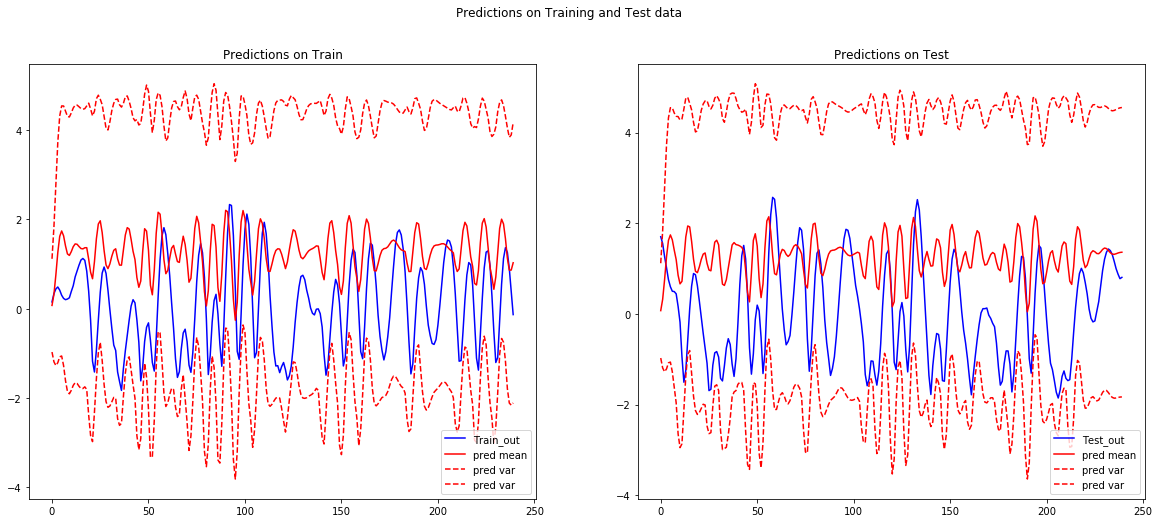

In [40]:
# Plot predictions
def plot_predictions(fig_no,posterior_train, posterior_test=None, layer_no = None):
    """
    Plots the output data along with posterior of the layer.
    Used for plotting the hidden states or
    
    layer_no: int or Normal posterior
        plot states of this layer (0-th is output). There is also some logic about compting
        the MSE, and aligning with actual data.
    """
    
    if layer_no is None: #default
        layer_no = 1

    if posterior_test is None:
        no_test_data = True
    else:
        no_test_data = False

    if isinstance(posterior_train, list): 
        layer_in_list = len(predictions_train)-1-layer_no # standard layer no (like in printing the model)
        predictions_train_layer = predictions_train[layer_in_list]
    else:
        predictions_train_layer = posterior_train

    if not no_test_data:
        if isinstance(posterior_test, list): 
            predictions_test_layer = predictions_test[layer_in_list]
        else:
            predictions_test_layer = posterior_test

    # Aligning the data ->
    # training of test data can be longer than leyer data because of the initial window.
    if out_train.shape[0] > predictions_train_layer.mean.shape[0]:
        out_train_tmp = out_train[win_out:]
    else:
        out_train_tmp = out_train
        
    if out_test.shape[0] > predictions_test_layer.mean.shape[0]:
        out_test_tmp = out_test[win_out:]
    else:
        out_test_tmp = out_test
    # Aligning the data <-
        
    if layer_no == 0:
        # Not anymore! Compute RMSE ignoring first output values of length "win_out"
        train_rmse = [comp_RMSE(predictions_train_layer.mean,
                                out_train_tmp)]
        print("Train overall RMSE: ", str(train_rmse))
        
        if not no_test_data:
            # Compute RMSE ignoring first output values of length "win_out"
            test_rmse = [comp_RMSE(predictions_test_layer.mean,
                                   out_test_tmp)]
            print("Test overall RMSE: ", str(test_rmse))
    
    # Plot predictions:
    if not no_test_data:
        fig5 = plt.figure(10,figsize=(20,8))
    else:
        fig5 = plt.figure(10,figsize=(10,8))
        
    fig5.suptitle('Predictions on Training and Test data')
    if not no_test_data:
        ax1 = plt.subplot(1,2,1)
    else:
        ax1 = plt.subplot(1,1,1)
    ax1.plot(out_train_tmp, label="Train_out", color = 'b')
    ax1.plot( predictions_train_layer.mean, label = 'pred mean', color = 'r' )
    ax1.plot( predictions_train_layer.mean +\
                     2*np.sqrt( predictions_train_layer.variance ), label = 'pred var', color='r', linestyle='--' )
    ax1.plot( predictions_train_layer.mean -\
                     2*np.sqrt( predictions_train_layer.variance ), label = 'pred var', color='r', linestyle='--' )
    ax1.legend(loc=4)        
    ax1.set_title('Predictions on Train')

    if not no_test_data:
        ax2 = plt.subplot(1,2,2)
        ax2.plot(out_test_tmp, label="Test_out", color = 'b')

        ax2.plot( predictions_test_layer.mean, label = 'pred mean', color = 'r' )
        #ax2.plot( predictions_test_layer.mean +\
        #                 2*np.sqrt( predictions_test_layer.variance ), label = 'pred var', color='r', linestyle='--' )
        #ax2.plot( predictions_test_layer.mean -\
        #                 2*np.sqrt( predictions_test_layer.variance ), label = 'pred var', color='r', linestyle='--' )
        ax2.legend(loc=4)        
        ax2.set_title('Predictions on Test')

        del ax2
    del ax1 
plot_predictions(7,predictions_train, predictions_test , layer_no = 0)

In [41]:
predictions_test[-1].mean.shape


(1,)

In [42]:
comp_RMSE(np.zeros( (len(out_train[20:]),1) ), out_train[20:] )

0.99499977594340561

In [43]:
out_train[20:].mean(0)

array([ 0.04416444])

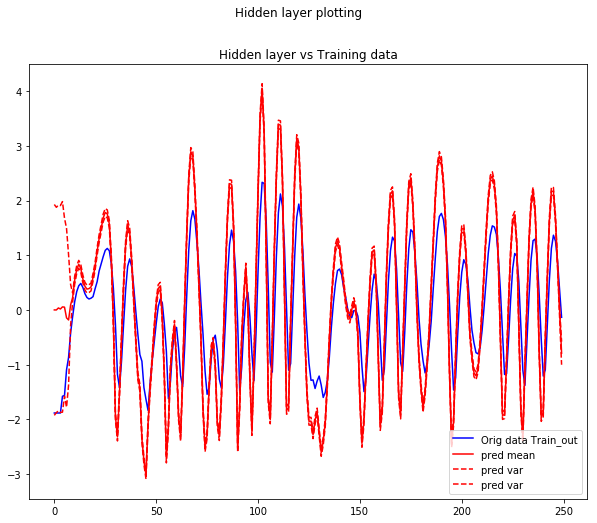

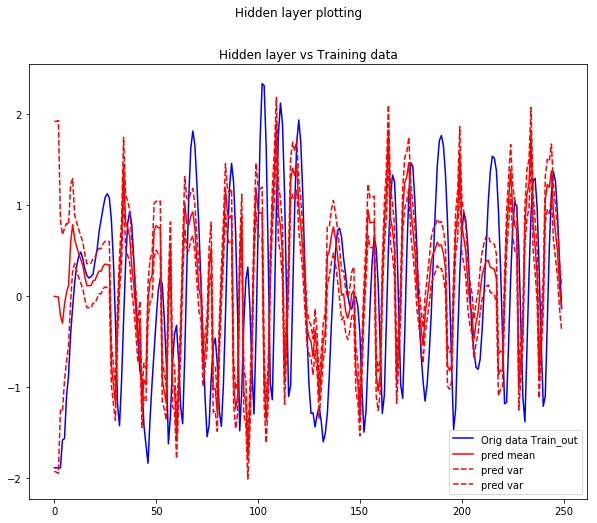

In [44]:
plot_hidden_states(8,m.layer_1.qX_0)
plot_hidden_states(9,m.layer_2.qX_0)